# Problem Statement

Most clustering algorithms try to group close-by points and create meaningful clusters. For instance, k-means clustering algorithm tries to create k clusters from the given data set such that the sum of the distances of each point from its cluster centroid is minimum. DBSCAN Algorithm groups points where distance between any two points is less than a specified limit.
 
In this assignment, we want to implement a different clustering algorithm. 

Given a set of points with their geo-coordinates and a weight associated with them, we want to create clusters of points which are in close proximity and the total weight of all the members of the cluster is less than a specified limit for each cluster. 

Small amount of data is provided in clustering_sample.csv file which contains latitude, longitude & weight of some points. Aim of this assignment is to create a function which takes this data file and cluster size as inputs and returns the cluster id of each data point as per the new clustering algorithm discussed above. 

You are expected to formulate and solve this problem as an optimization problem. Also, you are required to code a basic solution which should not take more than 2-3 days. You are also required to write a report on what you think are the possible approaches for solving this problem statement along with the pros and cons of each approach you mention.

# Candidate Solution

The new clustering method should create clusters of points based on proximity but is also constrained by the maximum weight the cluster can take on. To add some context to this problem, we can think of some scenarios where such an algorithm would be useful and look for the best algorithm for the problem.

Delhivery is in the business of logistics and supply chain. We can imagine a scenario as each of the points $x_i$ representing a pick up point for a package, the weight $w_i$ representing the weight of the package(s). If Delhivery wanted to optimally batch pick-up locations so as to assign them to a pick-up driver, one could imagine using this algorithm to cluster the $x_i$ such that they are in close proximity but the total weight does not exceed the capacity $W$ of the pick-up vehicle. This is a capacity constrained vehicle routing problem (but we do not have the number of vehicles explicitly stated).

Alternatively, the points $x_i$ could represent a set of $n$ locations to be fulfilled by a set of distribution centers/facilites. The clusters could be thought of the best set of points (based on proximity) to be fulfilled by a single distribution center (centroid of the cluster). The weight of each point, $w_i$, would represent the demand at each location, $x_i$. Max weight of the cluster, $W$, would represent the maximum capacity that can be fulfilled by a particular distribution center.

Now both these scenarios have the same end goal, clustering points with a maximum weight that can be taken up by a cluster. However, the algorithms that would be optimal for either case could be vastly different. 

For example, in the first scenario, we would use DBSCAN as it minimizes the total distance traversed when visiting each point. Further, it is not inhibited by centre of the of cluster and hence can form non globular clusters (e.g. clustering a set of points in a straight line).

The second scenario, on the other hand, we want all points to be close to a centroid (the distribution center), and hence want to minimize within cluster sum of squares. This represents K-Means more closely and the algorithm would minimize the distances of the points from the centroid.

So when it comes to proximity, of data points, DBSCAN gives a cluster where the minimum distance between any two points is always small but maximum can be large, i.e. variance of distance between any two points in cluster is large. Where as in K-Means, the variance of distance between any two points in the cluster is smaller.

## _Formulation_

We can formulate the above problem as a Capacitated Clustering Problem (CCP) such:

\begin{equation*}
\begin{array}{l@{\quad} r c r c r}
\text{maximize: }   &\sum_{k=1}^{p} \sum_{i=1}^{n-1} \sum_{j>i}^{n} c_{ij} x_{ik} x_{jk} &        & \\
\text{subject to: }
                    &\sum_{k=1}^{p} x_{ik}                                               &    =   & 1      & i=1 ,..., n\\
                    &\sum_{i=1}^{n} w_i x_{ik}                                           &  \leq  & W      & k=1 ,..., p\\
                    &x_{ik}                                                              &   \in  &\{0,1\} & i=1 ,..., n &k=1 ,..., p\\
\end{array}
\end{equation*}

The objective function maximizes the joint benefit, $c_{ij}$, of every pair of points ($x_i, x_j$) in a cluster ($k$). The first set of constraints forces the assignment of each element to a cluster. The second set of constraints forces the sum of the weights of the pairs of elements in the same cluster to be below $W$. We have $n$ points and $p$ clusters. Since we don't want to specify the number of clusters, we can set $p = n$. So we will have $n$ clusters which captures the lower bound of the objective when every point is assigned to cluster, but when applied, many of the n clusters will have 0 points assigned to them. The benefit, $c_{ij}$ can be defined as $1/d_{ij}$ where $d_{ij} = ||x_i - x_j||$. Therefore, we'll have points closer together having a high benefit.

This type of formulation ensures close proximity of any point to every other point in the cluster. However, in the case of a complete graph structure (every node connected to every other node), the optimizer is also incentivized to cluster far away points when lacking options. We can prevent this by either not allowing a complete graph or assigning negative benefit with:


$$ d_{ij}  =    \left\{
\begin{array}{ll}
      d_{ij} & d_{ij}  <  r \\
     -d_{ij} & d_{ij} \geq  r \\
\end{array} 
\right.
$$
 
Solving this Quadritic Integer Program Combinatorial Optimization is computationally expensive.  So we will look for tractable solutions.

### Modified K-Means

We can implement a variant of k-means algorithm but we search for the best k using silhouette scores that prioritize separability of clusters. This is a more brute-force algorithm in searching for the best cluster and it does not focus on joint similarity of points but rather closeness to cluster center. We might see cases where two points in separate clusters are very close to each other and ideally would belong to the same cluster. Further, k-means for a given k is inherently a NP-hard optimization and hence finding the best clusters for a given k is also approximate and not the best solution.

In [1]:
import numpy as np # for linear algebra 
import pandas as pd # for reading data
from pathlib import Path # to resolve path issues 
import matplotlib.pyplot as plt # plot data
import pulp # for optimization
import random
import math

In [2]:
data_path = Path.cwd()/'data'

data = pd.read_csv(data_path/'clustering_sample.csv', 
                        usecols=['point_id', 'latitude', 'longitude', 'weight'])

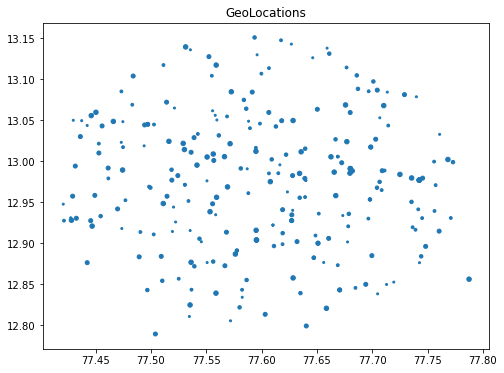

In [3]:
plt.figure(figsize = (8, 6))
plt.scatter(data['longitude'], data['latitude'], s = data['weight']*4)
plt.title('GeoLocations')
plt.show()

In [4]:
def l2_distance(point1, point2):
    return sum([(float(i)-float(j))**2 for (i,j) in zip(point1, point2)])

In [5]:
def format_data(data):
    data_coordinates = [list(a) for a in zip(data['latitude'], data['longitude'])]
    data_weights = data['weight'].values
    return(data_coordinates, data_weights)

In [6]:
class subproblem(object):
    def __init__(self, centroids, coordinates, weights, max_weight):

        # list of length k containing centroids of clusters
        self.centroids = centroids 
        # list of length n containing tuple coordinates of data points
        self.coordinates = coordinates 
        # list of length n containing weights of data points
        self.weights = weights
        # scalar value of max weight of cluster
        self.max_weight = max_weight

        self.n = len(coordinates)
        self.k = len(centroids)

        self.create_model()

    def create_model(self):
        def distances(assignment):
            return l2_distance(self.coordinates[assignment[0]], self.centroids[assignment[1]])

        clusters = list(range(self.k))
        assignments = [(i, j)for i in range(self.n) for j in range(self.k)]

        # DEFINE DECISION VARIABLES
        # outflow variables for data nodes.
        self.y = pulp.LpVariable.dicts('data-to-cluster_assignments',
                                  assignments,
                                  lowBound=0,
                                  upBound=1,
                                  cat=pulp.LpInteger)

        # OBJECTIVE FUNCTION
        # create the model
        self.model = pulp.LpProblem("Model_for_assignment_subproblem", pulp.LpMinimize)

        # objective function
        self.model += pulp.lpSum([distances(assignment) * self.y[assignment] for assignment in assignments])

        # CONSTRAINTS ON DECISION VARIABLES
        # 1. constraints on the total weights of clusters
        for j in range(self.k):
            self.model += pulp.lpSum([self.weights[i] * self.y[(i, j)] for i in range(self.n)]) <= self.max_weight, "maximum_weight_for_cluster {}".format(j)

        # 2. make sure each point is assigned at least once, and only once
        for i in range(self.n):
            self.model += pulp.lpSum([self.y[(i, j)] for j in range(self.k)]) == 1, "must_assign_point {}".format(i)


    def solve(self):
        self.status = self.model.solve()
        
        clusters = None
        if self.status == 1:
            clusters= [-1 for i in range(self.n)]
            for i in range(self.n):
                for j in range(self.k):
                    if self.y[(i, j)].value() > 0:
                        clusters[i] = j
        return clusters

In [7]:
def initialize_centers(dataset, k):
    """
    sample k random coordinates centroid initialization
    """
    ids = list(range(len(dataset)))
    random.shuffle(ids)
    return [dataset[id] for id in ids[:k]]

def compute_centers(clusters, dataset):
    """
    determine centroids of clusters
    """
    # canonical labeling of clusters
    ids = list(set(clusters))
    c_to_id = dict()
    for j, c in enumerate(ids):
        c_to_id[c] = j
    for j, c in enumerate(clusters):
        clusters[j] = c_to_id[c]

    k = len(ids)
    dim = len(dataset[0])
    cluster_centers = [[0.0] * dim for i in range(k)]
    cluster_counts = [0] * k
    for j, c in enumerate(clusters):
        for i in range(dim):
            cluster_centers[c][i] += dataset[j][i]

        cluster_counts[c] += 1
    
    for c in range(k):
        for i in range(dim):
            cluster_centers[c][i] = cluster_centers[c][i] / cluster_counts[c]

    return clusters, cluster_centers

def kmeans_weighted(dataset, k, weights, max_weight, max_iters=999, uiter = None):
    """
    Parameters:
    dataset - numpy matrix (or list of lists) - of point coordinates
    k - number of clusters
    weights - list of point weights, length equal to len(@dataset)
    min_weight - minimum total weight per cluster
    max_weight - maximum total weight per cluster
    max_iters - if no convergence after this number of iterations, stop anyway
    """
    n = len(dataset)
    uiter = uiter or list
    centers = initialize_centers(dataset, k)
    clusters = [-1] * n

    for ind in uiter(range(max_iters)):
        m = subproblem(centers, dataset, weights, max_weight)
        clusters_ = m.solve()
        if not clusters_:
            return None, None
        clusters_, centers = compute_centers(clusters_, dataset)

        converged = all([clusters[i]==clusters_[i] for i in range(n)])
        clusters = clusters_
        if converged:
            break

    return clusters, centers

def cluster_quality(cluster):
    if len(cluster) == 0:
        return 0.0

    quality = 0.0
    for i in range(len(cluster)):
        for j in range(i, len(cluster)):
            quality += l2_distance(cluster[i], cluster[j])
    return quality / len(cluster)

def compute_quality(data, cluster_indices):
    clusters = dict()
    for i, c in enumerate(cluster_indices):
        if c in clusters:
            clusters[c].append(data[i])
        else:
            clusters[c] = [data[i]]
    return sum(cluster_quality(c) for c in clusters.values())

In [8]:
# coordinates, weights = format_data(data)

# max_weight = 50
# k = 20
# NUM_ITER = 10
# best = None
# best_clusters = None
# for i in range(NUM_ITER):
#     clusters, centers = kmeans_weighted(coordinates, k, weights, max_weight)
#     if clusters:
#         quality = compute_quality(coordinates, clusters)
#         if not best or (quality < best):
#             best = quality
#             best_clusters = clusters

In [9]:
from sklearn.metrics import silhouette_score

def run_clustering(data, max_weight, early_stopping = 3):
    data_coordinates, weights = format_data(data)
    if max_weight < max(weights):
        raise('Error! max_weight must be larger than largest weight!')

    # Min number of clusters
    min_k = math.ceil(1.2*(sum(weights)/max_weight))

    # Max number of clusters = n*0.5
    max_k = math.floor(len(data_coordinates)*0.3)

    # Number of clusters k to explore = 10% of max_k - min_k. i.e. 10% of the range
    num_k = math.floor(0.05 * (max_k - min_k))
    step_size = math.floor((max_k - min_k)/num_k)
    k_values = list(range(min_k, max_k, step_size))
    scores, k_clusters = [], []
    NUM_ITER = 4
    for k in k_values:
        best = None
        best_clusters = None
        stopper = 0
        counter = 0
        while counter < NUM_ITER and stopper < early_stopping:
            counter += 1
            clusters, centers = kmeans_weighted(data_coordinates, k, weights, max_weight)
            if clusters:
                quality = compute_quality(data_coordinates, clusters)
                if not best or (quality < best):
                    best = quality
                    best_clusters = clusters
                    stopper = 0
                stopper += 1
        scores.append(silhouette_score(data_coordinates, best_clusters))
        k_clusters.append(best_clusters)
    ind = scores.index(max(scores))
    return k_clusters[ind]

In [10]:
import seaborn as sns
from matplotlib.colors import ListedColormap

def plot_clusters(data, clusters):
    data['cluster'] = clusters
    k = data['cluster'].nunique()
    plt.figure(figsize = (8, 6))
    plt.scatter(data['longitude'], data['latitude'], 
                s = data['weight']*4, 
                c = data['cluster'], 
                cmap = ListedColormap(sns.color_palette(None, k)))
    plt.title('GeoLocations')
    plt.show()
    return(None)

In [11]:
# Takes about 10 mins to run on 16GB Ram
best_clusters = run_clustering(data, max_weight = 50)


1
solution
2
solution
3
solution
4
solution
1
solution
2
solution
3
solution
4
solution
1
solution
2
solution
3
solution


Number of Clusters : 42


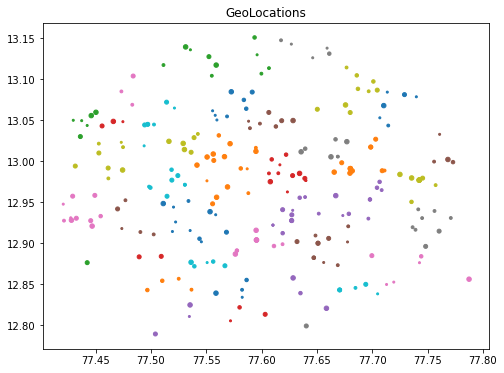

In [19]:
print('Number of Clusters : {}'.format(len(set(best_clusters))))
plot_clusters(data, best_clusters)

The above K-Means has some pros and some cons: <br>
**Pros:** <br>
While it is not computationally efficient for variable number of clusters, if we can assign a cost to a cluster based on business knowledge, it could be an elegant solution. For example, in the case of facility/distribution centre location, if we can assign the fixed cost of establishing a distribution center and incorporate that in the cost function, we could also optimize for $k$, number of clusters and have an elegant and quick solution to the problem.

**Cons**: <br>
In the absence of business information on clusters, it is a computationally expensive algorithm iterating over possible values of K. It also inherently favors more clusters to fewer clusters from the objective. It can also place two points which are very close together in separate clusters and hence would not be ideal in a vehicle routing problem scenario. Might fail for small value of $W$ due to lack of options. Would need to start with high number of clusters.




### Alternatives

The best algorithm would depend on the use case, business constraints and the data. As mentioned becfore, k-means like algorithms lends itself well to facility location problems where as DBSCAN like algorithms are great for vehicle routing problems. We explore some of the alternatives below.

1. **Hierarchical Clustering:** <br>
This is far more efficient algorithm, we can use either agglomerative (bottom-up) or divisive (top-down) hierarchical clustering. If using divisive, we keep initialize by assigning all points to a single cluster and then keep dividing the clusters based on distance until all clusters satisfy the max-weight constraint. We can use a variety of linkages as well to represent the type of clusters we want. Single linkage will give us clusters more like DBSCAN while complete/average linkages will give us clusters more like k-means and CCP. It also does not need any parameters such as number of clusters. However, it be harder to implement and code up. It's also a more greedy approach and will not lead to the most optimal clustering.


2. **Spectral Clustering:** <br>
Normalized cuts is a new technique used in graphical clustering. We can connect the nodes as a bipartite graph, or we could eleminate certain edges based on distance to ensure the points don't end up in a cluster. Edges in the graph represent a similarity score and the clusters are created by iteratively removing edges and partition the graph. The objective is to minimize the cut value (sum of edges removed) using a technique called normalized cuts. Refer : https://repository.upenn.edu/cgi/viewcontent.cgi?article=1101&context=cis_papers. This is a great techniuqe as well, all nodes need not be connected to all other nodes and we can constrain some of the connections to prevent bad matching. We could add the additional constraint of ensuring weights of cluster is below $W$. This technique is also computationally expensive as discussed in the paper. 


3. **Maximal Covering Location Problem:** <br>
This is based on the problem of optimally placing facilities (such a hospitals/fire stations), so as to maximize coverage of the facilities while minimizing the number of facilities used. This can also be formulated as a LP which makes it tractable. But it requires pre-determined nodes for placing facilities. Also, it is hard constrained, i.e. if a point A which is close to a cluster C does not satisfy the constraint and hence can't be assigned to the cluster, point B which is slightly further away from cluster C and satisfies the constraint can't be a part of the cluster. http://www.geog.ucsb.edu/~forest/G294download/MAX_COVER_RLC_CSR.pdf



All the above methods reduce the number of clusters used but need not minimize the proximity of points in a cluster. Depending on the use-case and data, the optimal algorithm could be different.